# Classification Models for Fraud Protection
## CPE 695 Final Project Team 1
#### Authors: Nicholas Benelli, Gokulkumar Krishnakumar, Samruth Vennapusala

Data:
    https://archive.ics.uci.edu/ml/datasets/Audit+Data

In [1]:
# Packages
import pandas as pd
import numpy as np
import warnings
from IPython.display import Image, HTML, display
import pydotplus
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Decison Tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# Ensemble
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# NN
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from matplotlib.colors import ListedColormap
# SVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import PolynomialFeatures

# My Packages
import helper

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# Variables
output_col = "Risk"
test_size = 0.2    # Test size in test train split
data_filepath = 'audit_data'
test_accuracy_dict = {}
keep_columns = ['Sector_score', 'LOCATION_ID', 'PARA_A', 'PARA_B', 
                'Money_Value', 'District_Loss', 'History', 'Risk']

## Get Data

In [3]:
df_audit = pd.read_csv('/'.join([data_filepath, 'audit_risk.csv']))

In [4]:
display(df_audit)

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
0,3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,...,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,1
1,3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,...,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,0
2,3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,...,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,0
3,3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,...,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,1
4,3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,...,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,55.57,9,0.49,0.2,0.098,0.40,0.2,0.080,0.89,5.0,...,0.4,0,0.2,0.0,2.0,1.578,0.4,0.5,0.3156,0
772,55.57,16,0.47,0.2,0.094,0.37,0.2,0.074,0.84,5.0,...,0.4,0,0.2,0.0,2.0,1.568,0.4,0.5,0.3136,0
773,55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5.0,...,0.4,0,0.2,0.0,2.0,1.456,0.4,0.5,0.2912,0
774,55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5.0,...,0.4,0,0.2,0.0,2.0,1.440,0.4,0.5,0.2880,0


## Clean Data
Fill nas in database with aveage of column. Only raw input values will be used for classifier and binary risk output column

In [5]:
df_audit1 = helper.fill_nas_df(df_audit.copy())
df = df_audit1.loc[:, keep_columns]

In [6]:
display(df)

,Sector_score,LOCATION_ID,PARA_A,PARA_B,Money_Value,District_Loss,History,Risk
0,3.89,23,4.18,2.50,3.38,2,0,1
1,3.89,6,0.00,4.83,0.94,2,0,0
2,3.89,6,0.51,0.23,0.00,2,0,0
3,3.89,6,0.00,10.80,11.75,2,0,1
4,3.89,6,0.00,0.08,0.00,2,0,0
...,...,...,...,...,...,...,...,...
771,55.57,9,0.49,0.40,0.00,2,0,0
772,55.57,16,0.47,0.37,0.00,2,0,0
773,55.57,14,0.24,0.04,0.00,2,0,0
774,55.57,18,0.20,0.00,0.00,2,0,0


In [7]:
# Drop location ID
df = df.drop(columns= ['LOCATION_ID'])

In [8]:
# Test Train Split
X = df.copy().drop(columns = output_col)
y = df.copy().loc[:, output_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size)

In [9]:
print(f'Training data size: {X_train.shape}')
print(f'Testing data size: {X_test.shape}')

Training data size: (620, 6)
Testing data size: (156, 6)


## Decision Tree

### Simple 1 Node Decision Tree 

In [10]:
# Simple Decision Tree
branches = 1
model_name = f'Decision Tree: {branches} Node '
tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=branches)
tree_clf = tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

Decision Tree: 1 Node  Classification Report: 

               precision    recall  f1-score   support

           0       0.77      0.97      0.86        91
           1       0.93      0.60      0.73        65

    accuracy                           0.81       156
   macro avg       0.85      0.78      0.79       156
weighted avg       0.84      0.81      0.80       156

Decision Tree: 1 Node  Accuracy: 0.8141



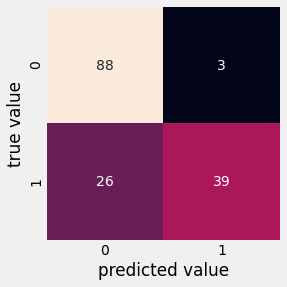

In [11]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

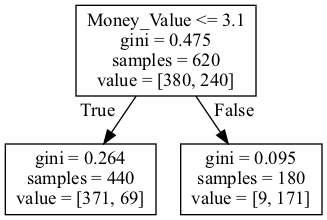

In [12]:
data_dt = sklearn.tree.export_graphviz(tree_clf, out_file=None,feature_names= X_train.columns)
graph = pydotplus.graph_from_dot_data(data_dt)
Image(graph.create_png())

### No Max Nodes 

In [13]:
# Descision Tree No Max Nodes
model_name = 'Decision Tree: No Max Nodes'
tree_clf = sklearn.tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

tree_clf.tree_.node_count

43

Decision Tree: No Max Nodes Classification Report: 

               precision    recall  f1-score   support

           0       0.95      0.99      0.97        91
           1       0.98      0.92      0.95        65

    accuracy                           0.96       156
   macro avg       0.97      0.96      0.96       156
weighted avg       0.96      0.96      0.96       156

Decision Tree: No Max Nodes Accuracy: 0.9615



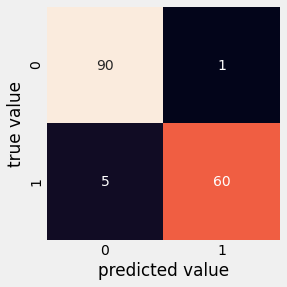

In [14]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

#### Observation
The accuracy is excellent, but the tree needs to be pruned.  The worry is overfitting with the data.

### Tree Branches vs Accuracy

In [15]:
# Loop through number of branches and test accuracy of training and testing data
branches = 2
test_accuracy_list = []
train_accuracy_list = []
branches_list = []
for branches in range(100):
    branches += 1
    branches_list.append(branches)
    model_name = f'{branches} Node Decision Tree'
    tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=branches)
    tree_clf = tree_clf.fit(X_train, y_train)
    y_pred_test = tree_clf.predict(X_test)
    y_pred_train = tree_clf.predict(X_train)
    test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_test)
    train_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred_train)
    test_accuracy_list.append(test_accuracy)
    train_accuracy_list.append(train_accuracy)

branches_array = np.array(branches_list)
test_accuracy_array = np.array(test_accuracy_list)
train_accuracy_array = np.array(train_accuracy_list)

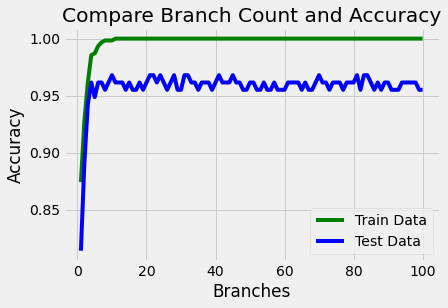

In [16]:
# Branch Count to Accuracy
plt.plot(branches_array, train_accuracy_array, 'g',label = 'Train Data')
plt.plot(branches_array, test_accuracy_array, 'b',label = 'Test Data')
plt.xlabel('Branches')
plt.ylabel('Accuracy')
plt.title('Compare Branch Count and Accuracy')
plt.legend()
plt.show()

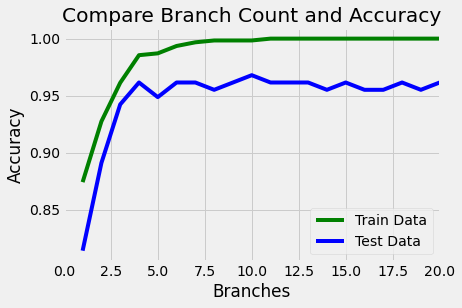

In [17]:
plt.plot(branches_array, train_accuracy_array, 'g',label = 'Train Data')
plt.plot(branches_array, test_accuracy_array, 'b',label = 'Test Data')
plt.xlim((0,20))
plt.xlabel('Branches')
plt.ylabel('Accuracy')
plt.title('Compare Branch Count and Accuracy')
plt.legend()
plt.show()

#### Observation
6 to 11 Branches sees like the optimal amount of branches during pruning by comparing the accuracy fo the testing data and training data to the branches.  The accuracy of the test data is diverges from the training data and decreases. 

### Pruned Tree 

In [18]:
test_params = {
    'criterion': ['gini','entropy'],
    'max_leaf_nodes': list(range(1,10)),
}

grid_clf = GridSearchCV(estimator=DecisionTreeClassifier(),
                     param_grid=test_params,
                     scoring='accuracy',
                     cv=10,
                     n_jobs=-1)


grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

In [19]:
best_params = grid_clf.best_params_
print("Best parameters: {}".format(best_params))
#max_leaf_nodes = best_params['max_leaf_nodes']
max_leaf_nodes = 6

Best parameters: {'criterion': 'gini', 'max_leaf_nodes': 9}


#### Observation
The Grid Search CV agrees with the Branch vs Accuracy plot. The tree will be pruned to the above amount of branches.

In [52]:
# Pruned Descision Tree 
model_name = f'Pruned Decision Tree: {max_leaf_nodes} Nodes'
tree_clf = sklearn.tree.DecisionTreeClassifier(
    criterion = best_params['criterion'], max_depth= max_leaf_nodes)
tree_clf = tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

Pruned Decision Tree: 6 Nodes Classification Report: 

               precision    recall  f1-score   support

           0       0.95      0.99      0.97        91
           1       0.98      0.92      0.95        65

    accuracy                           0.96       156
   macro avg       0.97      0.96      0.96       156
weighted avg       0.96      0.96      0.96       156

Pruned Decision Tree: 6 Nodes Accuracy: 0.9615



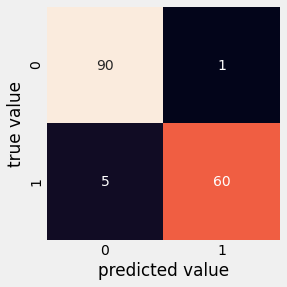

In [53]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

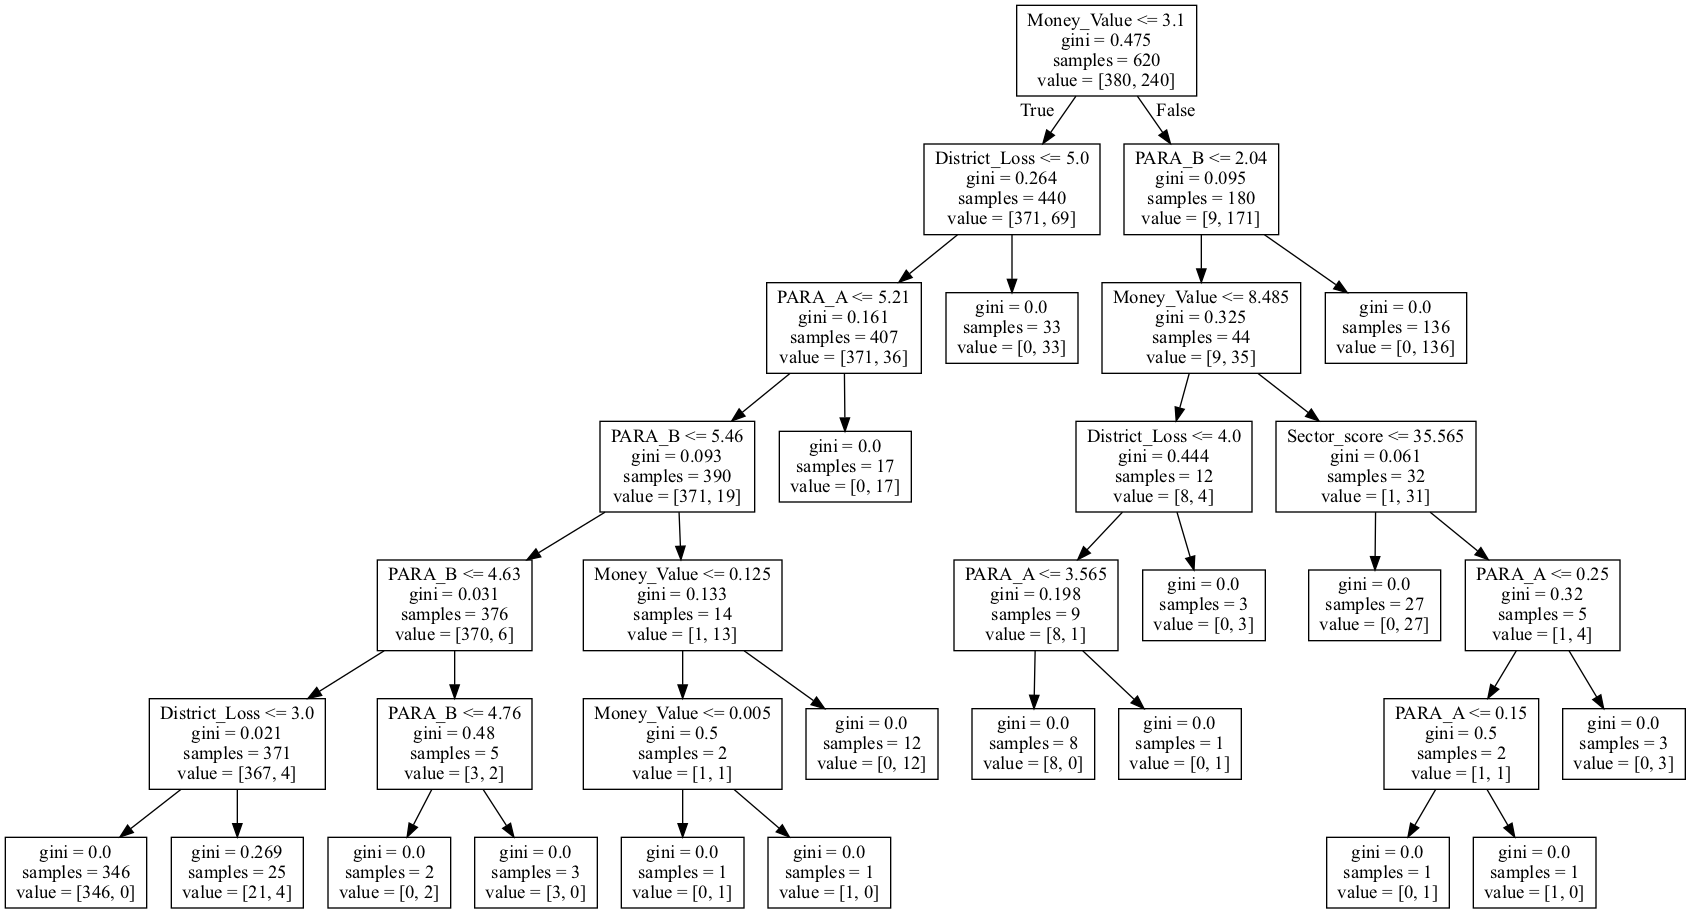

In [54]:
#Plot Decision Tree
data_dt = sklearn.tree.export_graphviz(tree_clf, out_file=None,feature_names= X_train.columns)
graph = pydotplus.graph_from_dot_data(data_dt)
Image(graph.create_png())

### Random Forest
Random forest will reduce overfitting by taking the decision tree and running X iterations of it and averaging the iterations together.

In [23]:
model_name = 'Random Forest'
print(f'{model_name} Max Depth: {max_leaf_nodes}')
# Random Forrest
forest_clf = RandomForestClassifier(
    max_depth=max_leaf_nodes, 
    criterion = best_params['criterion'],
    random_state=0, 
    n_estimators=50)
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)

Random Forest Max Depth: 6


#### Random Tree in Random Forest

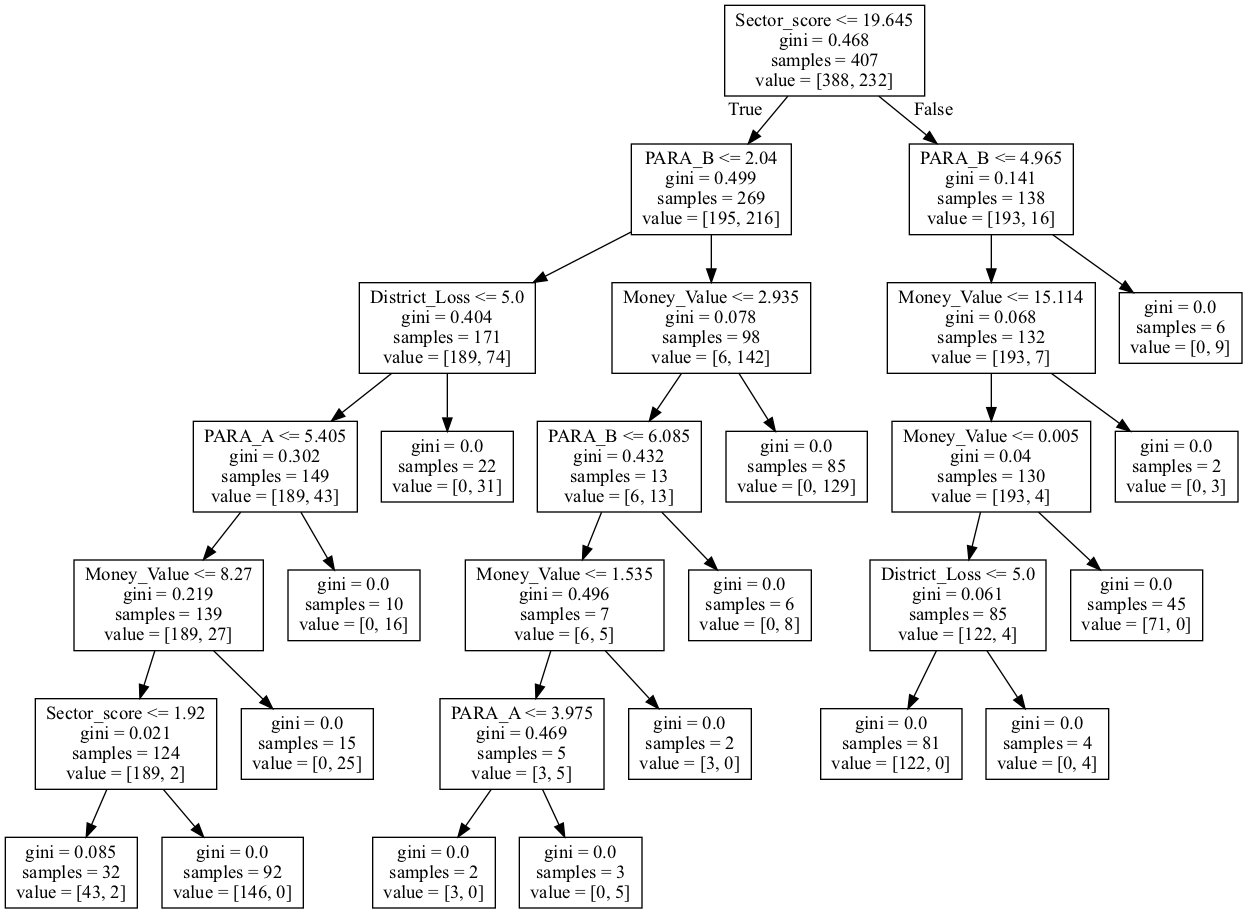

In [24]:
# Random Tree in Random Forest
random_index = np.random.randint(0,len(forest_clf.estimators_)-1)
random_tree = forest_clf.estimators_[random_index]

#Plot  Random Decision Tree
data_dt = export_graphviz(random_tree, out_file=None,feature_names= X_train.columns)
graph = pydotplus.graph_from_dot_data(data_dt)
Image(graph.create_png())

Random Forest Classification Report: 

               precision    recall  f1-score   support

           0       0.97      0.97      0.97        91
           1       0.95      0.95      0.95        65

    accuracy                           0.96       156
   macro avg       0.96      0.96      0.96       156
weighted avg       0.96      0.96      0.96       156

Random Forest Accuracy: 0.9615



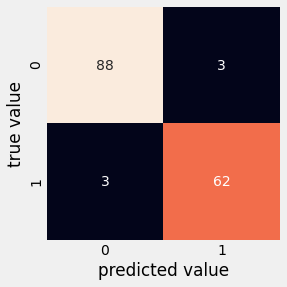

In [25]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

#### Observation:
Random forest has slightly decreased accuracy from the decision tree, but reduces the varaince and does not increase the bias.  This will lead to a better model if more data is introduced. 

## AdaBoost

### AdaBoost with 1 Node Decision Tree 

In [26]:
model_name = 'AdaBoost: 1 Node Tree'
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200, algorithm='SAMME.R', learning_rate= 0.5)

ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

AdaBoost: 1 Node Tree Classification Report: 

               precision    recall  f1-score   support

           0       0.95      0.99      0.97        91
           1       0.98      0.92      0.95        65

    accuracy                           0.96       156
   macro avg       0.97      0.96      0.96       156
weighted avg       0.96      0.96      0.96       156

AdaBoost: 1 Node Tree Accuracy: 0.9615



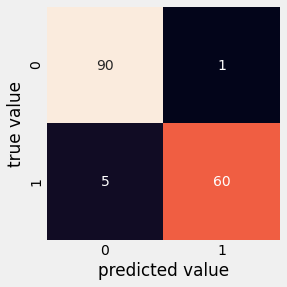

In [27]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

### Learning Rate vs. Accuracy

In [63]:
# Learn Rate vs Accuracy
learn_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
accuracy_list_train = []
accuracy_list_test = []
for learn_rate in learn_rates:
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), 
        n_estimators=200, algorithm='SAMME.R', learning_rate= learn_rate)
    
    ada_clf.fit(X_train, y_train)
    y_pred_test = ada_clf.predict(X_test)
    y_pred_train = ada_clf.predict(X_train)
    accuracy_list_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_list_test.append(accuracy_score(y_test, y_pred_test))
    
learn_rates_array = np.array(learn_rates)
accuracy_array_train = np.array(accuracy_list_train)
accuracy_array_test = np.array(accuracy_list_test)

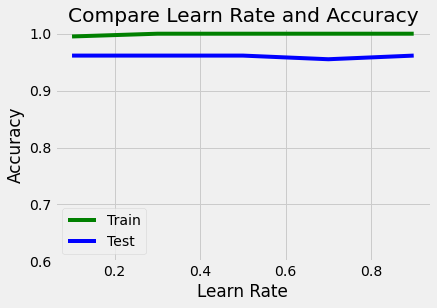

In [66]:
# Learn Rate to Accuracy
plt.plot(learn_rates_array, accuracy_array_train, 'g',label = 'Train')
plt.plot(learn_rates_array, accuracy_array_test, 'b',label = 'Test')
plt.ylim((0.6, 1.01))
plt.xlabel('Learn Rate')
plt.ylabel('Accuracy')
plt.title('Compare Learn Rate and Accuracy')
plt.legend()
plt.show()

## AdaBoost with Pruned Tree 

In [30]:
model_name = 'AdaBoost: Pruned Tree'
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=6), 
    n_estimators=200, algorithm='SAMME.R', learning_rate= 0.5)

ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

AdaBoost: Pruned Tree Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.99      0.96        91
           1       0.98      0.91      0.94        65

    accuracy                           0.96       156
   macro avg       0.96      0.95      0.95       156
weighted avg       0.96      0.96      0.95       156

AdaBoost: Pruned Tree Accuracy: 0.9551



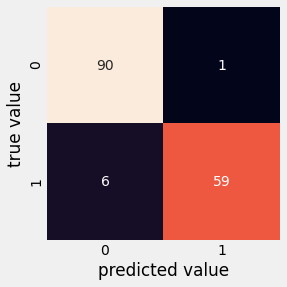

In [31]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

### AdaBoost with Random Forest Pruned Tree

In [32]:
model_name = 'AdaBoost: Random Forest'
ada_clf = AdaBoostClassifier(
    RandomForestClassifier(max_depth=6), 
    n_estimators=200, algorithm='SAMME.R', learning_rate= 0.5)

ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

AdaBoost: Random Forest Classification Report: 

               precision    recall  f1-score   support

           0       0.95      0.98      0.96        91
           1       0.97      0.92      0.94        65

    accuracy                           0.96       156
   macro avg       0.96      0.95      0.95       156
weighted avg       0.96      0.96      0.95       156

AdaBoost: Random Forest Accuracy: 0.9551



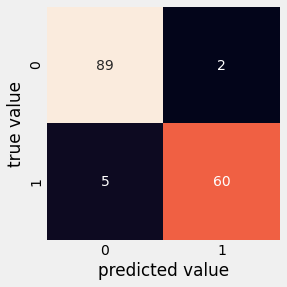

In [33]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

### Iterations vs. Accuracy

In [69]:
# Number of Estimmators
estim_rates = [10, 50, 100, 150, 200, 400, 500, 1000]
accuracy_list_train = []
accuracy_list_test = []
branches = 6
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=branches), 
    n_estimators=10, algorithm='SAMME.R', learning_rate= 0.5)

for estim in estim_rates:
    ada_clf.n_estimators= estim
    ada_clf.fit(X_train, y_train)
    y_pred_test = ada_clf.predict(X_test)
    y_pred_train = ada_clf.predict(X_train)
    accuracy_list_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_list_test.append(accuracy_score(y_test, y_pred_test))
    
estim_rates_array = np.array(estim_rates)
accuracy_array_train = np.array(accuracy_list_train)
accuracy_array_test = np.array(accuracy_list_test)

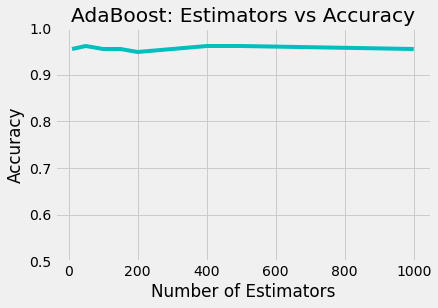

In [74]:
# Estimator to Accuracy
#plt.plot(estim_rates_array, accuracy_array_train, 'purple',label = 'Train')
plt.plot(estim_rates_array, accuracy_array_test, 'c',label = 'Test')
plt.ylim((.5, 1.0001))
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('AdaBoost: Estimators vs Accuracy')
plt.show()

## Neural  Neworks

### Perceptron
Perceptron will be implemented in a 2D Plot of the main two inputs. The accuracy of the perceptron can be seen in the plot

In [36]:
col_a = 'PARA_A'
col_b = 'Money_Value'

X_train_percept = X_train.loc[:, [col_a,col_b]].copy()
X_test_percept = X_test.loc[:, [col_a,col_b]].copy()
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X_train_percept, y_train)

Perceptron(random_state=42)

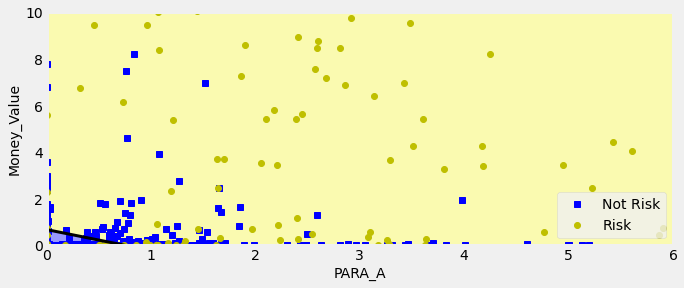

In [37]:
# Plot Perceptron
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 6, 0, 10]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(X_train_percept.loc[y==0, col_a], X_train_percept.loc[y==0, col_b], "bs", label="Not Risk")
plt.plot(X_train_percept.loc[y==1, col_a], X_train_percept.loc[y==1, col_b], "yo", label="Risk")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)

custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel(col_a, fontsize=14)
plt.ylabel(col_b, fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
plt.show()

### Optimize Nueral Network 

In [38]:
mlp = MLPClassifier(max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(2,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [39]:
print("...Optimizing hyperparameters")
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print('complete')

...Optimizing hyperparameters
complete


In [40]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (2,), 'learning_rate': 'constant', 'solver': 'sgd'}


In [41]:
model_name = 'MLP'
mlp = MLPClassifier(
    solver=clf.best_params_['solver'],
    hidden_layer_sizes=(2,),
    activation=clf.best_params_['activation'],
    learning_rate=clf.best_params_['learning_rate'],
    learning_rate_init=0.1,
    alpha=clf.best_params_['alpha'], 
    max_iter = 200,
    momentum=0.4)


In [42]:
iter_nums = []
test_accuracy_list = []
train_accuracy_list = []
for i in range(10, 1011, 100):
    iter_nums.append(i)
    mlp.max_iter = i
    mlp = mlp.fit(X_train, y_train)
    y_pred_test = mlp.predict(X_test)
    y_pred_train = mlp.predict(X_train)
    test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_test)
    train_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred_train)
    test_accuracy_list.append(test_accuracy)
    train_accuracy_list.append(train_accuracy)

iter_nums_array = np.array(iter_nums)
test_accuracy_array = np.array(test_accuracy_list)
train_accuracy_array = np.array(train_accuracy_list)

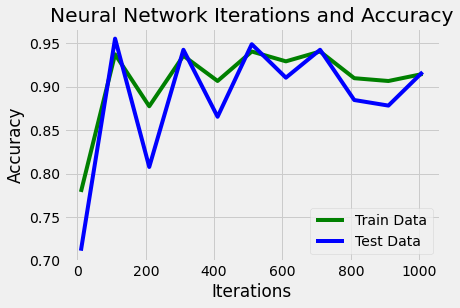

In [43]:
# Iteration to Accuracy
plt.plot(iter_nums_array, train_accuracy_array, 'g',label = 'Train Data')
plt.plot(iter_nums_array, test_accuracy_array, 'b',label = 'Test Data')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Neural Network Iterations and Accuracy')
plt.legend()
plt.show()

#### Observation: 
200 iterations seems provide the most accuracy without overfitting

In [44]:
mlp.max_iter = 200
mlp = mlp.fit(X_train, y_train)
y_predicted = mlp.predict(X_test)

MLP Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.98      0.96        91
           1       0.97      0.91      0.94        65

    accuracy                           0.95       156
   macro avg       0.95      0.94      0.95       156
weighted avg       0.95      0.95      0.95       156

MLP Accuracy: 0.9487



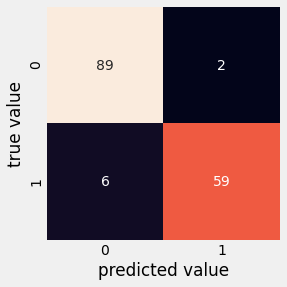

In [45]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

## SVM 

### SVM Linear

In [77]:
model_name = 'SVM: Linear'
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge')),
])
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

SVM: Linear Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.98      0.96        91
           1       0.97      0.91      0.94        65

    accuracy                           0.95       156
   macro avg       0.95      0.94      0.95       156
weighted avg       0.95      0.95      0.95       156

SVM: Linear Accuracy: 0.9487



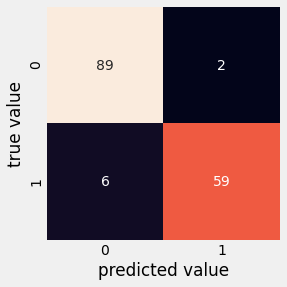

In [78]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

### SVM Polynomial 

In [79]:
model_name = 'SVM: Polynomial'
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=4)), 
    ('scaler', StandardScaler()), 
    ('svm_clf', LinearSVC(C=10, loss='hinge'))
])

polynomial_svm_clf.fit(X_train, y_train)
y_predicted = polynomial_svm_clf.predict(X_test)

SVM: Polynomial Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.98      0.96        91
           1       0.97      0.91      0.94        65

    accuracy                           0.95       156
   macro avg       0.95      0.94      0.95       156
weighted avg       0.95      0.95      0.95       156

SVM: Polynomial Accuracy: 0.9487



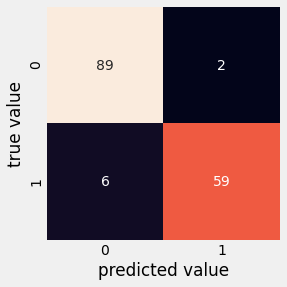

In [80]:
accuracy_data = helper.accuracy_table(y_test, y_pred, test_name= model_name)
test_accuracy_dict[model_name] = accuracy_data

## Test Comparison

In [50]:
df_accuracy = pd.DataFrame(test_accuracy_dict).transpose().reset_index(drop= True).iloc[:,:-1]
df_accuracy


,Test Name,TP,TN,FP,FN,Accuracy,Precision,Recall,F1 Score
0,Decision Tree: 1 Node,39,88,3,26,0.8141,0.9286,0.6,0.729
1,Decision Tree: No Max Nodes,60,90,1,5,0.9615,0.9836,0.9231,0.9524
2,Pruned Decision Tree: 6 Nodes,59,90,1,6,0.9551,0.9833,0.9077,0.944
3,Random Forest,62,88,3,3,0.9615,0.9538,0.9538,0.9538
4,AdaBoost: 1 Node Tree,60,90,1,5,0.9615,0.9836,0.9231,0.9524
5,AdaBoost: Pruned Tree,59,90,1,6,0.9551,0.9833,0.9077,0.944
6,AdaBoost: Random Forest,60,89,2,5,0.9551,0.9677,0.9231,0.9449
7,MLP,59,89,2,6,0.9487,0.9672,0.9077,0.9365
8,SVM: Linear,59,89,2,6,0.9487,0.9672,0.9077,0.9365
9,SVM: Polynomial,59,89,2,6,0.9487,0.9672,0.9077,0.9365


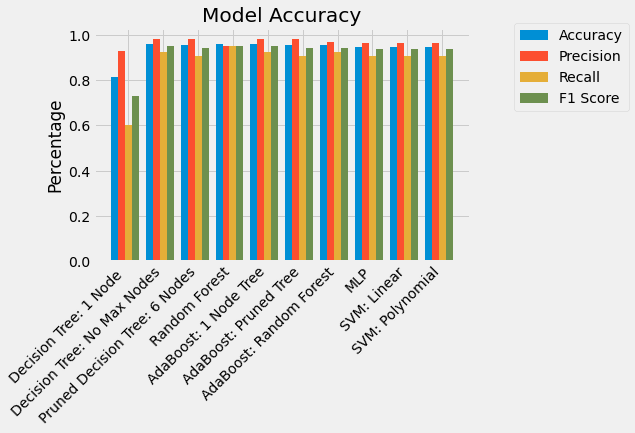

In [51]:
# Bar Graph- Accuracy
N = 4
ind = np.arange(N) 
width = 0.25


X_axis = np.arange(len(df_accuracy.loc[:, 'Test Name']))

# Plot
test1 = 'Accuracy'
plt.bar(X_axis - 0.4, df_accuracy.loc[:, test1], 0.2, label = test1)
test1 = 'Precision'
plt.bar(X_axis - 0.2, df_accuracy.loc[:, test1], 0.2, label = test1)
test1 = 'Recall'
plt.bar(X_axis - 0.0, df_accuracy.loc[:, test1], 0.2, label = test1)
test1 = 'F1 Score'
plt.bar(X_axis + 0.2, df_accuracy.loc[:, test1], 0.2, label = test1)


plt.xticks(X_axis, df_accuracy.loc[:, 'Test Name'], rotation=45, ha="right")
plt.ylabel("Percentage")
plt.title("Model Accuracy")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()